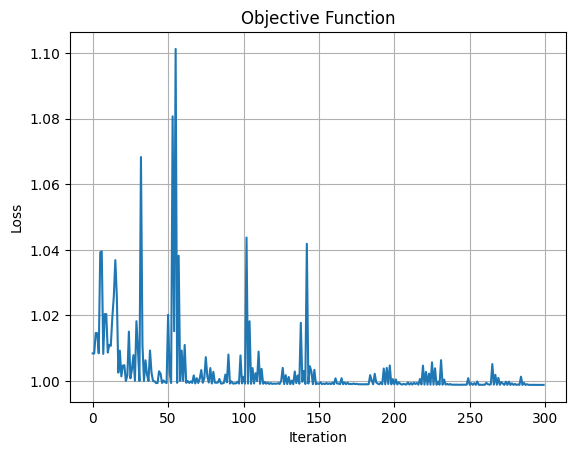

✅ Train Accuracy: 50.42%
✅ Test Accuracy : 49.93%


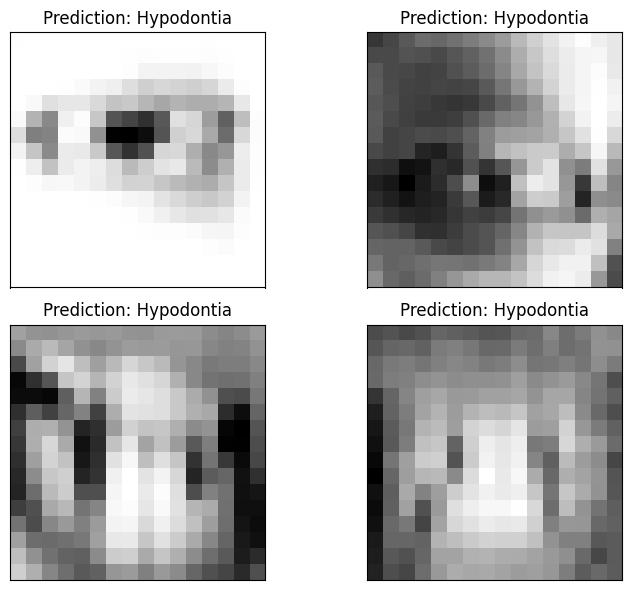

In [2]:
# Installing specified versions to ensure compatibility
!pip install qiskit==1.4.2 qiskit-machine-learning==0.8.2 qiskit_algorithms
!pip install pandas numpy matplotlib scikit-learn tensorflow qiskit
!pip install pylatexenc

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.primitives import Estimator
from IPython.display import clear_output

# --- Load and Normalize Image Data ---
def load_images_from_folder(folder_path, label):
    images, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.JPG')):
            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img = img.resize((16, 16), Image.BILINEAR)
            flat = np.array(img).flatten().astype(np.float32)
            norm = np.linalg.norm(flat)
            if norm > 0:
                flat = flat / norm  # Amplitude encoding
                images.append(flat)
                labels.append(label)
    return images, labels

# --- Paths to your image folders ---
folder_calculus = "/content/drive/MyDrive/Colab Notebooks/data/calculus"
folder_hypodontia = "/content/drive/MyDrive/Colab Notebooks/data/hypodontia"

# --- Load images and labels ---
images1, labels1 = load_images_from_folder(folder_calculus, +1)
images2, labels2 = load_images_from_folder(folder_hypodontia, -1)

all_images = np.array(images1 + images2)
all_labels = np.array(labels1 + labels2)

# --- Safety check before proceeding ---
assert len(all_images) > 0, "No images loaded! Check your folder paths or file formats."
assert all_images.shape[1] == 256, f"Expected 256 features, got {all_images.shape[1]}"

# --- Train/Test Split ---
x_train, x_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42
)

# --- Quantum Circuit Layers (same structure as your QCNN) ---
def conv_circuit(params):
    qc = QuantumCircuit(2)
    qc.rz(-np.pi / 2, 1)
    qc.cx(1, 0)
    qc.rz(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    qc.ry(params[2], 1)
    qc.cx(1, 0)
    qc.rz(np.pi / 2, 0)
    return qc

def conv_layer(num_qubits, prefix):
    qc = QuantumCircuit(num_qubits)
    param_index = 0
    params = ParameterVector(prefix, length=num_qubits * 3)
    for q1, q2 in zip(range(0, num_qubits - 1, 2), range(1, num_qubits, 2)):
        qc.append(conv_circuit(params[param_index: param_index + 3]), [q1, q2])
        param_index += 3
    for q1, q2 in zip(range(1, num_qubits - 1, 2), list(range(2, num_qubits, 2)) + [0]):
        qc.append(conv_circuit(params[param_index: param_index + 3]), [q1, q2])
        param_index += 3
    return qc

def pool_circuit(params):
    qc = QuantumCircuit(2)
    qc.rz(-np.pi / 2, 1)
    qc.cx(1, 0)
    qc.rz(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    qc.ry(params[2], 1)
    return qc

def pool_layer(sources, sinks, prefix):
    qc = QuantumCircuit(len(sources) + len(sinks))
    param_index = 0
    params = ParameterVector(prefix, length=len(sources) * 3)
    for src, sink in zip(sources, sinks):
        qc.append(pool_circuit(params[param_index: param_index + 3]), [src, sink])
        param_index += 3
    return qc

# --- Build Ansatz ---
num_qubits = 8
ansatz = QuantumCircuit(num_qubits)
ansatz.compose(conv_layer(8, "c1"), inplace=True)
ansatz.compose(pool_layer([0,1,2,3], [4,5,6,7], "p1"), inplace=True)
ansatz.compose(conv_layer(4, "c2"), qubits=range(4,8), inplace=True)
ansatz.compose(pool_layer([0,1], [2,3], "p2"), qubits=range(4,8), inplace=True)
ansatz.compose(conv_layer(2, "c3"), qubits=range(6,8), inplace=True)
ansatz.compose(pool_layer([0], [1], "p3"), qubits=range(6,8), inplace=True)

# --- Input Encoding Layer (for amplitude encoding) ---
input_params = [ParameterVector(f"x{i}", 1)[0] for i in range(num_qubits)]
encoder = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    encoder.ry(input_params[i], i)

# --- Combine input + ansatz ---
qcircuit = QuantumCircuit(num_qubits)
qcircuit.compose(encoder, inplace=True)
qcircuit.compose(ansatz, inplace=True)

# --- EstimatorQNN ---
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qcircuit.decompose(),
    observables=observable,
    input_params=input_params,
    weight_params=ansatz.parameters,
    estimator=estimator
)

# --- Training ---
objective_vals = []
def callback_graph(w, val):
    clear_output(wait=True)
    objective_vals.append(val)
    plt.plot(objective_vals)
    plt.title("Objective Function")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),
    callback=callback_graph,
    initial_point=np.random.rand(len(qnn.weight_params))
)

classifier.fit(x_train[:, :8], y_train)
train_acc = classifier.score(x_train[:, :8], y_train)
test_acc = classifier.score(x_test[:, :8], y_test)

print(f"✅ Train Accuracy: {round(train_acc * 100, 2)}%")
print(f"✅ Test Accuracy : {round(test_acc * 100, 2)}%")

# --- Prediction Visualization ---
y_pred = classifier.predict(x_test[:, :8])
fig, ax = plt.subplots(2, 2, figsize=(8, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i//2, i%2].imshow(x_test[i].reshape(16, 16), cmap='gray')
    ax[i//2, i%2].set_title(f"Prediction: {'Calculus' if y_pred[i]==1 else 'Hypodontia'}")
plt.tight_layout()
plt.show()